<a href="https://colab.research.google.com/github/Andrian0s/ML4NLP1-2024-Tutorial-Notebooks/blob/main/exercises/ex5/ex5_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 5: LLM Prompting and Prompt Engineering Part 2

In part 2, we experiment with prompting instruction-tuned Large Language Models (LLMs), and evaluate their performance on a linguistic annotation task involving structured outputs.

The goal of this assignment is to gain some experience working with instruction-tuned LLMs. To this end, you will learn how to

- query an instruction-tuned LLM with default chat templates (`Llama-3.2-3B-Instruct`)
- parse LLM outputs for structured responses using JSON and `Pydantic`
- implement error handling for edge cases where the model fails to output the expected data format.

The task we use for this purpose is a simple Tokenization and Part-of-Speech tagging task using data taken from Universal Dependencies.

To facilitate working with LLMs, we will again use the Unsloth library. Note that Unsloth provides both freeware and closed-source proprietary software. For our purposes, the freeware is sufficient! For more information on Unsloth, see the docs here.

This notebook is adapted from [this example](https://colab.research.google.com/drive/1T5-zKWM_5OD21QHwXHiV9ixTRR7k3iB9?usp=sharing) by Unsloth.


### NOTE: Expected execution times
We have provided expected execution times throughout the notebook as a guide. These are intended to be approximate, but should give you some idea for what to expect. If your runtimes far exceed these expected execution times, you may want to consider modifying your approach. These are denoted with ⌛ .

### NOTE: GPU Usage
It is expected that you load the model onto a GPU for inference. For other parts of the code, such as data preparation, a GPU is not necessary. To avoid waiting for resources unnecessarily, we recommend doing as much as you can on a CPU instance and change the runtime type as necessary. We've highlight the cells that need a GPU with ⚡

## 1) Installing dependencies

In [1]:
%%capture
!pip install levenshtein
!pip install unsloth
# Also get the latest nightly Unsloth!
!pip uninstall unsloth -y && pip install --upgrade --no-cache-dir "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"

In [2]:
# check unsloth version
expected_version = '2024.10.2'
unsloth_version = !pip list | grep -P 'unsloth\s+' | grep -Po '\S+$'
if unsloth_version[0] != expected_version:
    print(f"Warning! Found Unsloth version {unsloth_version[0]} but expected {expected_version}.")

# check python version
import sys
print(sys.version)

# check gpu info
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

# check RAM info
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Warning! Found Unsloth version 2024.11.10 but expected 2024.10.2.
3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]
Mon Dec  2 08:58:33 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   35C    P8              11W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                        

## 2) Model Loading

In [3]:
from unsloth import FastLanguageModel
import torch

max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

# Note, here we specify the instruction-tuned version of Llama-3.2-3B
model_name = "unsloth/Llama-3.2-3B-Instruct"

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = model_name,
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
    )


FastLanguageModel.for_inference(model) # Enable native 2x faster inference

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2024.11.10: Fast Llama patching. Transformers:4.46.2.
   \\   /|    GPU: NVIDIA L4. Max memory: 22.168 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 8.9. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/54.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 3072, padding_idx=128004)
    (layers): ModuleList(
      (0-27): 28 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=3072, out_features=3072, bias=False)
          (k_proj): Linear4bit(in_features=3072, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=3072, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=3072, out_features=3072, bias=False)
          (rotary_emb): LlamaExtendedRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=3072, out_features=8192, bias=False)
          (up_proj): Linear4bit(in_features=3072, out_features=8192, bias=False)
          (down_proj): Linear4bit(in_features=8192, out_features=3072, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((3072,), eps=1e-05)
        (post_attention_layernorm): Llam

## 3) Data Loading and Preparation

In [4]:
# load data
import random
import pandas as pd

seed = 42

random.seed(seed)

dataset_url = "https://raw.githubusercontent.com/tannonk/prompting_exercise/refs/heads/main/data/en_ewt-ud-dev-pos.json"
df = pd.read_json(dataset_url, lines=True)

# For each input sentence, we'll build the target as a list of dictionaries containing keys for the token and pos tag. This is what we want our LLM annotator to predict.
df['target'] = df.apply(lambda x: [{'token': token, 'pos': pos} for token, pos in zip(x['tokens'].split(), x['upos'].split())], axis=1)

# We'll sample 100 items for testing purposes
test_data = df.sample(n=100, random_state=seed)
train_data = df.drop(test_data.index)

print(f"Train data: {len(train_data)}")
print(f"Test data: {len(test_data)}")

test_data.head()


Train data: 1408
Test data: 100


,sentence,tokens,upos,xpos,target
578,"""...there is no companion quite so devoted, so...",""" ... there is no companion quite so devoted ,...",PUNCT PUNCT PRON VERB DET NOUN ADV ADV ADJ PUN...,"`` , EX VBZ DT NN RB RB JJ , RB JJ , RB JJ CC ...","[{'token': '""', 'pos': 'PUNCT'}, {'token': '....."
1146,"Great computer repair store, highly recommended.","Great computer repair store , highly recommend...",ADJ NOUN NOUN NOUN PUNCT ADV VERB PUNCT,"JJ NN NN NN , RB VBN .","[{'token': 'Great', 'pos': 'ADJ'}, {'token': '..."
382,You wear your heart on your sleeve ... and sin...,You wear your heart on your sleeve ... and sin...,PRON VERB PRON NOUN ADP PRON NOUN PUNCT CCONJ ...,"PRP VBP PRP$ NN IN PRP$ NN , CC IN PRP VBP DT ...","[{'token': 'You', 'pos': 'PRON'}, {'token': 'w..."
583,for Books that Speak for Themselves....,for Books that Speak for Themselves ....,ADP NOUN PRON VERB ADP PRON PUNCT,"IN NNS WDT VBP IN PRP ,","[{'token': 'for', 'pos': 'ADP'}, {'token': 'Bo..."
966,yuck !!,yuck !!,INTJ PUNCT,UH .,"[{'token': 'yuck', 'pos': 'INTJ'}, {'token': '..."


### TODO: Inspect and describe the data

📝❓ What are the fields and their corresponding values in the dataframe?

The dataset has the following features:

- sentence: The raw text sentence, such as "Great computer repair store, highly recommended."
tokens: A list of tokenized words (or punctuation marks) extracted from the sentence, such as ["Great", "computer", "repair", "store", ",", "highly", "recommended", "."].
- upos: Universal Part-of-Speech (POS) tags corresponding to each token, using the Universal Dependencies standard. Examples include ADJ (adjective), NOUN, PUNCT (punctuation), VERB, etc.
- xpos: Language-specific POS tags, which provide finer-grained distinctions compared to upos. For instance, JJ is a language-specific POS tag for adjectives in English.
- target: A list of dictionaries, where each dictionary contains a token and its corresponding POS tag. For example:

📝❓ What is the difference between `upos` and `xpos`?

- upos (Universal POS tags): A set of standardized POS tags used across multiple languages, following the Universal Dependencies framework. These are coarse-grained categories like NOUN, VERB, ADJ, etc.
- xpos (Language-Specific POS tags): Finer-grained and specific to the language in use. For English, xpos tags follow the Penn Treebank convention, e.g., JJ (adjective), NN (singular noun), VB (base verb), etc.

📝❓ What is the distribution of `upos` labels in the `test_data`?

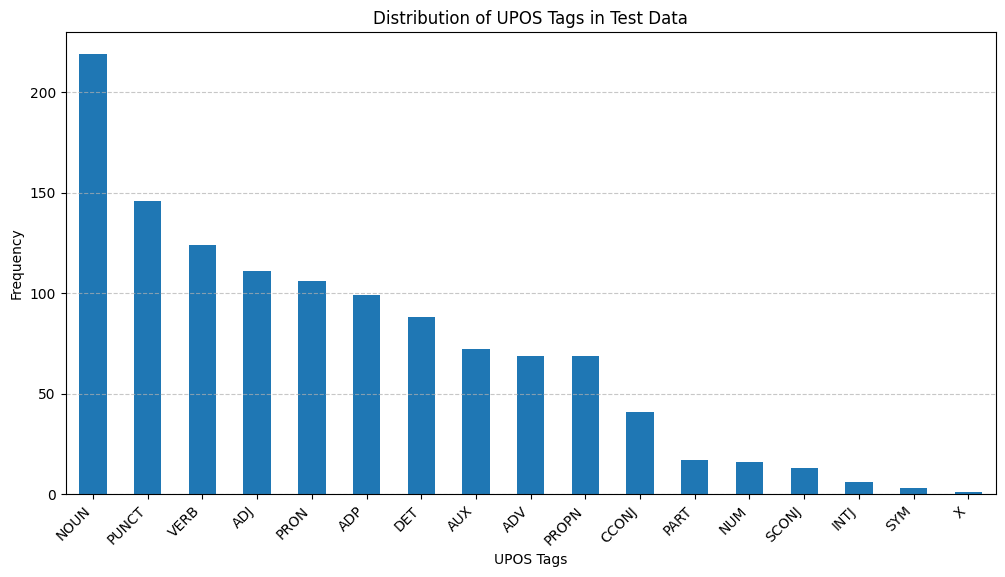

In [5]:
import matplotlib.pyplot as plt

# Function to plot the distribution of UPOS tags
def plot_upos_distribution(dataframe):
    upos_counts = dataframe['upos'].str.split().explode().value_counts()
    plt.figure(figsize=(12, 6))
    upos_counts.plot(kind='bar')
    plt.title("Distribution of UPOS Tags in Test Data")
    plt.xlabel("UPOS Tags")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Assuming test_data is already loaded
plot_upos_distribution(test_data)


### TODO: Define the basic `PromptTemplate`

Note, you can reuse the solution from part 1 of this exercise here.

In [6]:
# TODO

class PromptTemplate:
    def __init__(self, task_description, bos=tokenizer.bos_token, eos="\n\n"):
        self.task_description = task_description
        self.bos = bos  # Used for training prompt formatting
        self.eos = eos  # Used for training prompt formatting

    def zero_shot_prompt(self, input_text):
        """
        Generates a zero-shot prompt with the input text.

        Args:
            input_text (str): The input text for which the model will generate an output.

        Returns:
            str: The formatted zero-shot prompt.
        """
        prompt = f"{self.task_description}\n\n{input_text}\nAnswer:"

        return prompt

    def few_shot_prompt(self, input_text, examples=[], affix="\nAnswer:"):
        """
        Generates a few-shot prompt with examples.

        Args:
            examples (list of dict): A list of dictionaries where each dict contains 'input' and 'output' keys.
            input_text (str): The new input text for which the model will generate an output.
            affix (str, optional): A string to be appended to the end of the prompt. Defaults to "\nAnswer:".

        Returns:
            str: The formatted few-shot prompt.
        """

        # Start with task description
        prompt = f"{self.task_description}\n\n"

        # Add the examples
        for example in examples:
            prompt += f"Input: {example['input']}\nOutput: {example['output']}\n\n"

        # Add the new input (and affix if provided)
        prompt += f"Input: {input_text}{affix}"

        return prompt

    def training_prompt(self, input_text, target=None):
        """
        Generates a simple seq-to-seq style prompt that can be used for finetuning a base model.

        Args:
            input_text (str): The input text to be used in the prompt.
            target (str, optional): The target text to be used in the prompt. Defaults to None.

        Returns:
            str: The formatted prompt.
        """

        if target:
            # The training prompt format is typically "Input: <input_text>\nOutput: <target>"
            prompt = f"Input: {input_text}\nOutput: {target}"
        else:
            # In case no target is provided, it will only give the input, useful for tasks without target labels
            prompt = f"Input: {input_text}\nOutput:"

        return prompt

## 3.2 ChatTemplates

Instruction-tuned models are typically finetuned using a predefined `ChatTemplate`.
This means that when using them for inference, it is important that we use the correct `ChatTemplate` in order to avoid "confusing" the model.

You can find more information about model `ChatTemplates` for Huggingface models [here](https://huggingface.co/docs/transformers/en/chat_templating).


In [7]:
from unsloth.chat_templates import get_chat_template

# load the chat_template from unsloth (note, the logic is similar when using native Huggingface, but here we're using Unsloth!)
tokenizer = get_chat_template(
    tokenizer,
    chat_template = "llama-3.1", # for Llama-3.1 and Llama-3.2 models
)

# Inspect the template (note, it looks more complicated than it is!)
print(tokenizer.chat_template)


{{- bos_token }}
{%- if custom_tools is defined %}
    {%- set tools = custom_tools %}
{%- endif %}
{%- if not tools_in_user_message is defined %}
    {%- set tools_in_user_message = true %}
{%- endif %}
{%- if not date_string is defined %}
    {%- set date_string = "26 July 2024" %}
{%- endif %}
{%- if not tools is defined %}
    {%- set tools = none %}
{%- endif %}

{#- This block extracts the system message, so we can slot it into the right place. #}
{%- if messages[0]['role'] == 'system' %}
    {%- set system_message = messages[0]['content'] %}
    {%- set messages = messages[1:] %}
{%- else %}
    {%- set system_message = "" %}
{%- endif %}

{#- System message + builtin tools #}
{{- "<|start_header_id|>system<|end_header_id|>

" }}
{%- if builtin_tools is defined or tools is not none %}
    {{- "Environment: ipython
" }}
{%- endif %}
{%- if builtin_tools is defined %}
    {{- "Tools: " + builtin_tools | reject('equalto', 'code_interpreter') | join(", ") + "

"}}
{%- endif %}
{{- "

### TODO: Prepare your inputs using the `ChatTemplate` for the model.

Note, you should be able to drop your custom `PromptTemplate` string into the model's default `ChatTemplate`.


In [8]:
# TODO

# Prepare inputs using the ChatTemplate and the PromptTemplate class
def prepare_chat_inputs_with_prompt_template(dataframe, task_description, num_examples=5):
    """
    Prepares dataset examples for the ChatTemplate using the PromptTemplate class.

    Args:
        dataframe (pd.DataFrame): The dataset containing sentences and targets.
        task_description (str): The system-level task description.
        num_examples (int): Number of few-shot examples to include.

    Returns:
        list: A list of formatted messages for the ChatTemplate.
    """
    # Initialize the PromptTemplate
    prompt_template = PromptTemplate(task_description)

    # Initialize the list of messages
    messages = [{"role": "system", "content": task_description}]

    # Add few-shot examples
    examples = dataframe.sample(n=num_examples, random_state=42)
    for _, row in examples.iterrows():
        user_prompt = prompt_template.training_prompt(row["sentence"], str(row["target"]))
        messages.append({"role": "user", "content": user_prompt})
        messages.append({"role": "assistant", "content": str(row["target"])})

    return messages

# Example usage
task_description = "Tag each token in the sentence with its part of speech."
formatted_messages = prepare_chat_inputs_with_prompt_template(train_data, task_description)

# Add a test example
test_sentence = test_data.iloc[0]["sentence"]
formatted_messages.append({"role": "user", "content": test_sentence})

# Inspect the final messages
print(formatted_messages)



[{'role': 'system', 'content': 'Tag each token in the sentence with its part of speech.'}, {'role': 'user', 'content': 'Input: Not sure if I am going to buy 17" or 16" wheels for the winter.\nOutput: [{\'token\': \'Not\', \'pos\': \'PART\'}, {\'token\': \'sure\', \'pos\': \'ADJ\'}, {\'token\': \'if\', \'pos\': \'SCONJ\'}, {\'token\': \'I\', \'pos\': \'PRON\'}, {\'token\': \'am\', \'pos\': \'AUX\'}, {\'token\': \'going\', \'pos\': \'VERB\'}, {\'token\': \'to\', \'pos\': \'PART\'}, {\'token\': \'buy\', \'pos\': \'VERB\'}, {\'token\': \'17\', \'pos\': \'NUM\'}, {\'token\': \'"\', \'pos\': \'NOUN\'}, {\'token\': \'or\', \'pos\': \'CCONJ\'}, {\'token\': \'16\', \'pos\': \'NUM\'}, {\'token\': \'"\', \'pos\': \'NOUN\'}, {\'token\': \'wheels\', \'pos\': \'NOUN\'}, {\'token\': \'for\', \'pos\': \'ADP\'}, {\'token\': \'the\', \'pos\': \'DET\'}, {\'token\': \'winter\', \'pos\': \'NOUN\'}, {\'token\': \'.\', \'pos\': \'PUNCT\'}]'}, {'role': 'assistant', 'content': '[{\'token\': \'Not\', \'pos\': \

## 4) Inference Pipeline

### TODO: Define a function to run inference efficiently with an LLM

Note, you can use the same inference function from part 1 of this exercise here!

In [9]:
# Set up our inference pipeline for generation

# We'll set some default generation args that we'll pass to our inference function
# Following best practices, we'll use Pydantic class which helps with validation.
from pydantic import BaseModel

class Generation_Args(BaseModel):
    max_new_tokens: int
    temperature: float
    top_k: int
    top_p: float
    repetition_penalty: float
    do_sample: bool
    min_p: float
    num_return_sequences: int

# Here are some default generation args
generation_args = Generation_Args(
    max_new_tokens = 1024, # note, for this task, we're setting the max_new_tokens to be more appropriate
    temperature = 1.0,
    top_k = 0,
    top_p = 1.0,
    repetition_penalty = 1.0,
    do_sample = True,
    use_cache = True,
    min_p = 0.1,
    num_return_sequences = 1
)

import torch
from torch.utils.data import DataLoader

def run_batched_inference(prompts, model, tokenizer, batch_size=10, generation_args=generation_args):
    """
    Runs batched inference on a list of prompts using a given model and tokenizer.

    Args:
        prompts (list[str]): List of prompts that are passed to the model.
        model (): The model used for generation.
        tokenizer (): The tokenizer used for encoding and decoding the prompts.
        batch_size (int): Number of prompts to run batched inference on.
        generation_args (Generation_Args): Arguments controlling the generation process.

    Returns:
        List[str]: Generated outputs for each prompt.
    """
    outputs = []

    # Split prompts into batches
    for i in range(0, len(prompts), batch_size):
        batch_prompts = prompts[i:i + batch_size]

        # Tokenize the batch with padding
        tokenized_inputs = tokenizer(
            batch_prompts,
            return_tensors="pt",
            padding=True,
            truncation=True
        )

        # Move inputs to GPU if available
        if torch.cuda.is_available():
            tokenized_inputs = {key: val.cuda() for key, val in tokenized_inputs.items()}
            model.cuda()

        # Generate outputs using the model
        with torch.no_grad():
            batch_outputs = model.generate(
                input_ids=tokenized_inputs["input_ids"],
                attention_mask=tokenized_inputs["attention_mask"],
                max_new_tokens=generation_args.max_new_tokens,
                temperature=generation_args.temperature,
                top_k=generation_args.top_k,
                top_p=generation_args.top_p,
                repetition_penalty=generation_args.repetition_penalty,
                do_sample=generation_args.do_sample,
                num_return_sequences=generation_args.num_return_sequences
            )

        # Decode the generated outputs into text
        decoded_outputs = tokenizer.batch_decode(batch_outputs, skip_special_tokens=True)

        # Append the batch results to the final outputs
        outputs.extend(decoded_outputs)

    return outputs


### Example Usage

In [10]:
# Example usage for a single test datapoint

# Step 1: Prepare the inputs for the test datapoint
task_description = "Tag each token in the sentence with its part of speech."
formatted_messages = prepare_chat_inputs_with_prompt_template(train_data, task_description)

# Select a single test example
test_sentence = test_data.iloc[0]["sentence"]
test_prompt = formatted_messages.copy()
test_prompt.append({"role": "user", "content": test_sentence})

# Step 2: Convert formatted messages to plain text for inference
# Flatten the "messages" into a string that the model can process
test_prompt_text = "\n".join([f"{msg['role'].capitalize()}: {msg['content']}" for msg in test_prompt])

# Step 3: Run batched inference for the single test prompt
generated_output = run_batched_inference([test_prompt_text], model, tokenizer, batch_size=1)

# Step 4: Display the result
print("Test Input:")
print(f"Formatted Messages: {test_prompt}")
print("\nFlattened Prompt for Model:")
print(test_prompt_text)
print("\nGenerated Output:")
print(generated_output[0])  # Output is a list, so get the first element



Test Input:
Formatted Messages: [{'role': 'system', 'content': 'Tag each token in the sentence with its part of speech.'}, {'role': 'user', 'content': 'Input: Not sure if I am going to buy 17" or 16" wheels for the winter.\nOutput: [{\'token\': \'Not\', \'pos\': \'PART\'}, {\'token\': \'sure\', \'pos\': \'ADJ\'}, {\'token\': \'if\', \'pos\': \'SCONJ\'}, {\'token\': \'I\', \'pos\': \'PRON\'}, {\'token\': \'am\', \'pos\': \'AUX\'}, {\'token\': \'going\', \'pos\': \'VERB\'}, {\'token\': \'to\', \'pos\': \'PART\'}, {\'token\': \'buy\', \'pos\': \'VERB\'}, {\'token\': \'17\', \'pos\': \'NUM\'}, {\'token\': \'"\', \'pos\': \'NOUN\'}, {\'token\': \'or\', \'pos\': \'CCONJ\'}, {\'token\': \'16\', \'pos\': \'NUM\'}, {\'token\': \'"\', \'pos\': \'NOUN\'}, {\'token\': \'wheels\', \'pos\': \'NOUN\'}, {\'token\': \'for\', \'pos\': \'ADP\'}, {\'token\': \'the\', \'pos\': \'DET\'}, {\'token\': \'winter\', \'pos\': \'NOUN\'}, {\'token\': \'.\', \'pos\': \'PUNCT\'}]'}, {'role': 'assistant', 'content': '

## 4.1) Run Inference

### TODO: run inference!

⌛ 10-20 mins

⚡ GPU

In [11]:
# Step 1: Prepare inputs for all test examples using the PromptTemplate
task_description = "Tag each token in the sentence with its part of speech."
formatted_messages = prepare_chat_inputs_with_prompt_template(train_data, task_description)

# Step 2: Convert each test example into a flattened prompt
test_prompts = []
for _, row in test_data.iterrows():
    # Create a copy of the few-shot examples
    test_prompt = formatted_messages.copy()
    # Add the test sentence as a new user message
    test_prompt.append({"role": "user", "content": row["sentence"]})
    # Flatten the prompt into plain text
    test_prompt_text = "\n".join([f"{msg['role'].capitalize()}: {msg['content']}" for msg in test_prompt])
    test_prompts.append(test_prompt_text)

# Step 3: Run batched inference for all test prompts
generated_outputs = run_batched_inference(test_prompts, model, tokenizer)



## 5) Structured output validation

LLMs output text. But in practice, we often want structured data that we can process further with other automatic processes.

For this purpose, JSON is a good target data structure.


### TODO: Define a processing pipeline that extracts and validates the JSON response from the LLM.

Hint: For this you should use a combination of [`Regex`](https://www.w3schools.com/python/python_regex.asp) and [`Pydantic`](https://docs.pydantic.dev/latest/).

The output should be a valid json object with the following structure:

```json
[
    {"token": "there", "pos": "DET"}, # each dict contains a token and its corresponding POS-Tag.
    {"token": "is", "pos": "VERB"},
    {"token": "no", "pos": "ADJ"},
    {"token": "companion", "pos": "NOUN"},
    {"token": "quite", "pos": "ADV"},
    {"token": "so", "pos": "ADV"},
    {"token": "devoted", "pos": "ADV"},
    {"token": "so", "pos": "ADV"},
    ...
]
```

In [24]:
import re
import json
import ast
from pydantic import BaseModel, ValidationError
from typing import List, Dict, Union

class TokenPOS(BaseModel):
    token: str
    pos: str

def extract_and_validate_json(llm_output: str) -> Union[List[Dict], None]:
    """
    Extracts and validates JSON from the LLM output.

    Args:
        llm_output (str): The raw text output from the LLM.

    Returns:
        List[Dict]: A list of validated token-POS dictionaries, or None if invalid.
    """
    # Step 1: Extract JSON-like text using a more specific regex
    json_match = re.search(r"\[(?:\{.*?\}[, ]*)*\]", llm_output, re.DOTALL)
    if not json_match:
        return None  # No valid JSON found

    json_text = json_match.group()

    try:
        # Step 2: Parse the extracted JSON
        #json_text = json_text.replace('"', '\\"')  # Escape double quotes
        #parsed_json = json.loads(json_text)
        parsed_json = ast.literal_eval(json_text)

        # Step 3: Validate each token-POS pair
        validated_data = [TokenPOS(**item).dict() for item in parsed_json]

        return validated_data

    except (json.JSONDecodeError, ValidationError):
        print(f"Invalid JSON format in LLM output: {json_text}")  # Debugging line
        return None  # Return None if JSON is invalid or doesn't match the schema



In [25]:
processed_outputs = [extract_and_validate_json(output) for output in generated_outputs]


In [26]:
'''# prompt: based on the entire code, Define a processing pipeline that extracts and validates the JSON response from the LLM.

import json
import re
import regex
from typing import List, Dict

from pydantic import BaseModel, ValidationError


class TokenPOS(BaseModel):
    token: str
    pos: str


def extract_and_validate_json(llm_output: str) -> List[Dict]:
    """
    Extracts and validates JSON data from LLM output.

    Args:
        llm_output: The raw text output from the LLM.

    Returns:
        A list of dictionaries, where each dictionary represents a token and its POS tag,
        or None if the JSON extraction or validation fails.
    """

    json_match = regex.search(r"\[(?:.*\n?)*\]?", output, re.MULTILINE)
    if not json_match:
        return None

    json_text = json_match.group()
    if not json_text.endswith("]"):
        json_text += "]"
    if not json_text.startswith("["):
        json_text = "[" + json_text


    try:
        # Find the last occurrence of a JSON array to potentially avoid incomplete JSON
        match = re.findall(r"\[.*?\]", llm_output, re.DOTALL)

        if match:
            json_string = match[-1]  # Use the last match

            # Attempt to parse the JSON string
            data = json.loads(json_string)

            # Validate the JSON structure using Pydantic
            validated_data = [TokenPOS(**item).model_dump() for item in data]
            return validated_data
        else:
            print("No JSON array found in LLM output")
            return None

    except json.JSONDecodeError:
        print("Invalid JSON format in LLM output:", llm_output) # Print the problematic output for debugging
        return None

    except ValidationError as e:
        print(f"JSON validation error: {e}")
        return None


# Example usage (assuming generated_outputs from previous steps)
processed_outputs = []
for output in generated_outputs:
    processed_output = extract_and_validate_json(output)
    if processed_output:
        processed_outputs.append(processed_output)

processed_outputs[:10]'''

'# prompt: based on the entire code, Define a processing pipeline that extracts and validates the JSON response from the LLM.\n\nimport json\nimport re\nimport regex\nfrom typing import List, Dict\n\nfrom pydantic import BaseModel, ValidationError\n\n\nclass TokenPOS(BaseModel):\n    token: str\n    pos: str\n\n\ndef extract_and_validate_json(llm_output: str) -> List[Dict]:\n    """\n    Extracts and validates JSON data from LLM output.\n\n    Args:\n        llm_output: The raw text output from the LLM.\n\n    Returns:\n        A list of dictionaries, where each dictionary represents a token and its POS tag,\n        or None if the JSON extraction or validation fails.\n    """\n\n    json_match = regex.search(r"\\[(?:.*\n?)*\\]?", output, re.MULTILINE)\n    if not json_match:\n        return None\n\n    json_text = json_match.group()\n    if not json_text.endswith("]"):\n        json_text += "]"\n    if not json_text.startswith("["):\n        json_text = "[" + json_text\n\n\n    try:\n

## 6) *Evaluation*

In [27]:
# Below is some boilerplate evaluation code. You should not need to make any changes here.

import Levenshtein
import numpy as np
from typing import List, Dict

def evaluate_instance(target: List[Dict], prediction: List[Dict]):
    """
    Evaluates the accuracy of tokenization and part-of-speech (POS) tagging between a target and a predicted sequence.

    Args:
        target (List[Dict]): A list of dictionaries representing the target tokens and POS tags.
        prediction (List[Dict]): A list of dictionaries representing the predicted tokens and POS tags.

    Returns:
        dict: A dictionary containing the token-level accuracy ('Token Acc') and POS accuracy ('POS Acc').
    """

    # If there is no prediction, return zero accuracies
    if prediction is None:
        return {'Token Acc': 0, 'POS Acc': 0}

    # Extract tokens and POS tags from the target and prediction lists
    target_tokens = [item['token'] for item in target]
    target_pos = [item['pos'] for item in target]
    pred_tokens = [item['token'] for item in prediction]
    pred_pos = [item['pos'] for item in prediction]

    # Get alignment operations between the target and predicted tokens using Levenshtein.opcodes()
    opcodes = Levenshtein.opcodes(target_tokens, pred_tokens)

    # Initialize aligned lists to store tokens and POS tags after alignment
    aligned_target_tokens = []
    aligned_target_pos = []
    aligned_pred_tokens = []
    aligned_pred_pos = []

    # Iterate over each operation in the alignment
    for tag, i1, i2, j1, j2 in opcodes:
        # "equal" means the tokens in this range are identical in both sequences
        if tag == 'equal':
            aligned_target_tokens.extend(target_tokens[i1:i2])
            aligned_target_pos.extend(target_pos[i1:i2])
            aligned_pred_tokens.extend(pred_tokens[j1:j2])
            aligned_pred_pos.extend(pred_pos[j1:j2])
        # "replace" means tokens in this range are different between the target and prediction
        elif tag == 'replace':
            aligned_target_tokens.extend(target_tokens[i1:i2])
            aligned_target_pos.extend(target_pos[i1:i2])
            aligned_pred_tokens.extend(pred_tokens[j1:j2])
            aligned_pred_pos.extend(pred_pos[j1:j2])
        # "insert" means tokens were added in the prediction that are not in the target
        elif tag == 'insert':
            aligned_target_tokens.extend(['<MISSING>'] * (j2 - j1))  # Add placeholders for missing target tokens
            aligned_target_pos.extend(['<MISSING>'] * (j2 - j1))      # Add placeholders for missing target POS tags
            aligned_pred_tokens.extend(pred_tokens[j1:j2])
            aligned_pred_pos.extend(pred_pos[j1:j2])
        # "delete" means tokens are present in the target but missing in the prediction
        elif tag == 'delete':
            aligned_target_tokens.extend(target_tokens[i1:i2])
            aligned_target_pos.extend(target_pos[i1:i2])
            aligned_pred_tokens.extend(['<MISSING>'] * (i2 - i1))    # Add placeholders for missing predicted tokens
            aligned_pred_pos.extend(['<MISSING>'] * (i2 - i1))       # Add placeholders for missing predicted POS tags

    # Calculate token-level accuracy
    # We only consider positions where both target and prediction have valid tokens (i.e., not '<MISSING>')
    correct_tokens = [
        1 if tgt == pred else 0
        for tgt, pred in zip(aligned_target_tokens, aligned_pred_tokens)
        if tgt != '<MISSING>' and pred != '<MISSING>'
    ]
    token_accuracy = np.mean(correct_tokens) if correct_tokens else 0

    # Calculate POS accuracy
    # Only consider positions where tokens match and are not '<MISSING>'
    correct_pos = [
        1 if tgt_pos == pred_pos else 0
        for tgt_tok, pred_tok, tgt_pos, pred_pos in zip(aligned_target_tokens, aligned_pred_tokens, aligned_target_pos, aligned_pred_pos)
        if tgt_tok == pred_tok and tgt_tok != '<MISSING>'
    ]
    pos_accuracy = np.mean(correct_pos) if correct_pos else 0

    return {'Token Acc': token_accuracy, 'POS Acc': pos_accuracy}

def get_results(test_data: pd.DataFrame, processed_outputs: List[List[Dict]]):
    """
    Returns a summary dataframe by taking the average of the all results for tokenization and pos-tagging.
    """
    results = []
    for i in range(len(processed_outputs)):
        results.append(evaluate_instance(test_data.iloc[i]['target'], processed_outputs[i]))

    results = pd.DataFrame(results).mean()
    return results

In [28]:
# To get the results, you should be able to pass your test_data DataFrame and the processed_outputs from above...
get_results(test_data, processed_outputs)

,0
Token Acc,0.102193
POS Acc,0.631667


In [29]:
# Check the generated outputs:
print(generated_outputs[:5])  # Print the first 5 outputs

# Check the processed outputs:
print(processed_outputs[:5])  # Print the first 5 processed outputs

# Inspect the evaluate_instance function if needed:
for i in range(5):
    print(evaluate_instance(test_data.iloc[i]['target'], processed_outputs[i]))

['System: Tag each token in the sentence with its part of speech.\nUser: Input: Not sure if I am going to buy 17" or 16" wheels for the winter.\nOutput: [{\'token\': \'Not\', \'pos\': \'PART\'}, {\'token\':\'sure\', \'pos\': \'ADJ\'}, {\'token\': \'if\', \'pos\': \'SCONJ\'}, {\'token\': \'I\', \'pos\': \'PRON\'}, {\'token\': \'am\', \'pos\': \'AUX\'}, {\'token\': \'going\', \'pos\': \'VERB\'}, {\'token\': \'to\', \'pos\': \'PART\'}, {\'token\': \'buy\', \'pos\': \'VERB\'}, {\'token\': \'17\', \'pos\': \'NUM\'}, {\'token\': \'"\', \'pos\': \'NOUN\'}, {\'token\': \'or\', \'pos\': \'CCONJ\'}, {\'token\': \'16\', \'pos\': \'NUM\'}, {\'token\': \'"\', \'pos\': \'NOUN\'}, {\'token\': \'wheels\', \'pos\': \'NOUN\'}, {\'token\': \'for\', \'pos\': \'ADP\'}, {\'token\': \'the\', \'pos\': \'DET\'}, {\'token\': \'winter\', \'pos\': \'NOUN\'}, {\'token\': \'.\', \'pos\': \'PUNCT\'}]\nAssistant: [{\'token\': \'Not\', \'pos\': \'PART\'}, {\'token\':\'sure\', \'pos\': \'ADJ\'}, {\'token\': \'if\', \'p

## 7) Manipulating the system prompt

The system prompt is part of the `ChatTemplate` that can help to steer the model.


### TODO: Customise the system prompt for the intended task and re-run inference

Note, this is an experiment. You should try a few different system prompts and report the resulting performance in your report.


📝❓ What was the best system prompt you considered?

📝❓ Were you able to improve the performance by manipulating the system prompt? Please discuss.

⌛ 10-20 mins (per experiment run)

⚡ GPU

In [ ]:
'''# prompt:  Customise the system prompt for the intended task and re-run inference
# Note, this is an experiment. You should try a few different system prompts and report the resulting performance in your report.

class PromptTemplate:
    def __init__(self, task_description):
        self.task_description = task_description

    def training_prompt(self, sentence, target):
        # Customize the prompt template for training examples
        return f"Sentence: {sentence}\nTarget: {target}"


# Example usage with a modified system prompt
task_description_modified = "Your task is to analyze a sentence and provide a JSON array where each element is a dictionary representing a token and its corresponding part of speech tag.  Output *only* valid JSON."
formatted_messages_modified = prepare_chat_inputs_with_prompt_template(train_data, task_description_modified)


# ... (rest of the inference pipeline code, with the updated formatted_messages_modified)

test_prompts_modified = []
for _, row in test_data.iterrows():
    test_prompt = formatted_messages_modified.copy()
    test_prompt.append({"role": "user", "content": row["sentence"]})
    test_prompt_text = "\n".join([f"{msg['role'].capitalize()}: {msg['content']}" for msg in test_prompt])
    test_prompts_modified.append(test_prompt_text)

generated_outputs_modified = run_batched_inference(test_prompts_modified, model, tokenizer)

processed_outputs_modified = process_llm_output(generated_outputs_modified)

# Evaluate the modified results
get_results(test_data, processed_outputs_modified)'''

In [30]:
# Step 1: Update the system-level task description
custom_system_prompt = (
    "You are an intelligent language model tasked with tagging each token in a sentence "
    "with its corresponding part-of-speech (POS) tag. Output the results in the following JSON format:\n"
    "[\n    {\"token\": \"<token>\", \"pos\": \"<POS>\"}, \n    ...\n]\n"
    "Ensure the JSON structure is valid and includes no extra information."
)

# Step 2: Integrate the custom system prompt into the ChatTemplate
def prepare_inputs_with_custom_system_prompt(dataframe, system_prompt, num_examples=5):
    """
    Prepares dataset examples for the ChatTemplate with a custom system prompt.

    Args:
        dataframe (pd.DataFrame): The dataset containing sentences and targets.
        system_prompt (str): The custom system-level prompt.
        num_examples (int): Number of few-shot examples to include.

    Returns:
        list: A list of formatted messages for the ChatTemplate.
    """
    # Initialize the PromptTemplate
    prompt_template = PromptTemplate(system_prompt)

    # Initialize the list of messages with the custom system prompt
    messages = [{"role": "system", "content": system_prompt}]

    # Add few-shot examples
    examples = dataframe.sample(n=num_examples, random_state=42)
    for _, row in examples.iterrows():
        user_prompt = prompt_template.training_prompt(row["sentence"], str(row["target"]))
        messages.append({"role": "user", "content": user_prompt})
        messages.append({"role": "assistant", "content": str(row["target"])})

    return messages

# Step 3: Generate prompts for inference
formatted_messages = prepare_inputs_with_custom_system_prompt(train_data, custom_system_prompt)

# Select test examples and format them
test_prompts = []
for _, row in test_data.iterrows():
    # Copy the formatted messages and add the test sentence
    test_prompt = formatted_messages.copy()
    test_prompt.append({"role": "user", "content": row["sentence"]})
    test_prompt_text = "\n".join([f"{msg['role'].capitalize()}: {msg['content']}" for msg in test_prompt])
    test_prompts.append(test_prompt_text)

# Step 4: Run inference with the customized system prompt
generated_outputs = run_batched_inference(test_prompts, model, tokenizer)

# Step 5: Extract and validate JSON responses
processed_outputs = [ extract_and_validate_json(output) for output in generated_outputs]

# Step 6: Evaluate the results
results = get_results(test_data, processed_outputs)
print("Evaluation Results:")
print(results)


Evaluation Results:
Token Acc    0.102193
POS Acc      0.631667
dtype: float64


---

## 8) Lab report

📝❓ Write your lab report here addressing all questions in the notebook

### TODO: Inspect and describe the data

📝❓ What are the fields and their corresponding values in the dataframe?

The dataset has the following features:

- sentence: The raw text sentence, such as "Great computer repair store, highly recommended."
tokens: A list of tokenized words (or punctuation marks) extracted from the sentence, such as ["Great", "computer", "repair", "store", ",", "highly", "recommended", "."].
- upos: Universal Part-of-Speech (POS) tags corresponding to each token, using the Universal Dependencies standard. Examples include ADJ (adjective), NOUN, PUNCT (punctuation), VERB, etc.
- xpos: Language-specific POS tags, which provide finer-grained distinctions compared to upos. For instance, JJ is a language-specific POS tag for adjectives in English.
- target: A list of dictionaries, where each dictionary contains a token and its corresponding POS tag. For example:

📝❓ What is the difference between `upos` and `xpos`?

- upos (Universal POS tags): A set of standardized POS tags used across multiple languages, following the Universal Dependencies framework. These are coarse-grained categories like NOUN, VERB, ADJ, etc.
- xpos (Language-Specific POS tags): Finer-grained and specific to the language in use. For English, xpos tags follow the Penn Treebank convention, e.g., JJ (adjective), NN (singular noun), VB (base verb), etc.

📝❓ What is the distribution of `upos` labels in the `test_data`?


The distribution is dominated mostly by nouns, punct , adj, verb and pron. the remaining tags are relative less



📝❓ What was the best system prompt you considered?


custom_system_prompt = (
    "You are an intelligent language model tasked with tagging each token in a sentence "
    "with its corresponding part-of-speech (POS) tag. Output the results in the following JSON format:\n"
    "[\n    {\"token\": \"<token>\", \"pos\": \"<POS>\"}, \n    ...\n]\n"
    "Ensure the JSON structure is valid and includes no extra information."
)

📝❓ Were you able to improve the performance by manipulating the system prompt? Please discuss.


There were no noticeable improvements wth the custom prompt, the performance was way better in the example usage with the system prompt.